In [1]:
import yaml
import glob
from multiprocessing import Pool
import pickle
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

font = {'family' : 'arial',
        'size'   : 16}
mpl.rc('font', **font)
mpl.rc('lines', linewidth=2)
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2

In [2]:
with open('keren/meta.yaml', 'r') as file:
    meta_data = yaml.safe_load(file)

n_cell_types = len(list(meta_data['cell_types']))
n_markers = len(list(meta_data['channels']))

In [48]:
def process_data(filename):
    data = np.load(filename, allow_pickle=True)
    X = data['X']
    y = data['y']
    cell_types = data['cell_types'].item()

    whole_cell_y = y[:, :, :, 0].squeeze()
    n_cells = np.max(whole_cell_y) + 1
    # Normalize image # e.g., adaptive histogram normalization
    for channel in range(n_markers):
        img = X[:, :, channel]
        #norm_img = (img - np.min(img)) / (np.max(img) - np.min(img))
        norm_img = (img - np.mean(img)) / np.std(img)
        X[:,:, channel] = norm_img

    # Initialize a marker expression panel with shape=(number of celltypes, number of markers)
    panel = np.zeros((n_cell_types, n_markers))
    counter = np.zeros(n_cell_types)
    means_X_bycell = np.zeros((n_cells, n_markers))
        
    with tqdm() as pbar:
        pbar.reset(n_cells)

        # Iterate through all the cell views
        for i in range(n_cells):
            # Collect views of each cell and associated celltype
            cell_type = cell_types[i]
            counter[cell_type] += 1
            view = np.where(whole_cell_y == i)
            view_X = X[:, view[0], view[1], :]
            # Take the mean marker intensity for each marker
            means_X = np.mean(view_X, axis = 1)
            means_X_bycell[i, :] = means_X
            # Add the mean marker intensity to marker expression panel for the associated celltype
            panel[cell_type, :] = panel[cell_type, :] + means_X
            pbar.update()

    # Average the marker expression panel over all cell instances
    #averaged_panel = panel/counter.reshape(-1, 1)

    y_bycell = np.array(list(cell_types.values()))
    return means_X_bycell, y_bycell, panel, counter

In [49]:
image_files = glob.glob('keren/*.npz')
n_images = len(image_files)

panels = np.zeros((n_images, n_cell_types, n_markers))
counters = np.zeros((n_images, n_cell_types))

#should take less than 3 minutes if at least 40 cores are available
with Pool(n_images) as p:   

    for i, (means_X_bycell, y_bycell, panel, counter) in enumerate(p.map(process_data, image_files)):
        panels[i, :, :] = panel
        counters[i, :] = counter

        if i == 0:
            all_means_X_bycell = means_X_bycell
            all_y_bycell = y_bycell
        else:
            all_means_X_bycell = np.concatenate((all_means_X_bycell, means_X_bycell), axis=0) 
            all_y_bycell = np.concatenate((all_y_bycell, y_bycell), axis=0) 

In [50]:
counter = np.sum(counters, axis = 0)
panel = np.sum(panels, axis = 0)
averaged_panel = panel/counter.reshape(-1, 1)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5,
        33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5, 42.5, 43.5,
        44.5, 45.5, 46.5, 47.5, 48.5, 49.5, 50.5]),
 [Text(0.5, 0, 'Au'),
  Text(1.5, 0, 'B7H3'),
  Text(2.5, 0, 'Beta-catenin'),
  Text(3.5, 0, 'C'),
  Text(4.5, 0, 'CD11b'),
  Text(5.5, 0, 'CD11c'),
  Text(6.5, 0, 'CD138'),
  Text(7.5, 0, 'CD16'),
  Text(8.5, 0, 'CD163'),
  Text(9.5, 0, 'CD20'),
  Text(10.5, 0, 'CD209'),
  Text(11.5, 0, 'CD3'),
  Text(12.5, 0, 'CD31'),
  Text(13.5, 0, 'CD4'),
  Text(14.5, 0, 'CD45'),
  Text(15.5, 0, 'CD45RO'),
  Text(16.5, 0, 'CD56'),
  Text(17.5, 0, 'CD63'),
  Text(18.5, 0, 'CD68'),
  Text(19.5, 0, 'CD8'),
  Text(20.5, 0, 'CSF-1R'),
  Text(21.5, 0, 'Ca'),
  Text(22.5, 0, 'EGFR'),
  Text(23.5, 0, 'Fe'),
  Text(24.5, 0, 'FoxP3'),
  Text(25.5, 0, 'H3K27me3'),
  

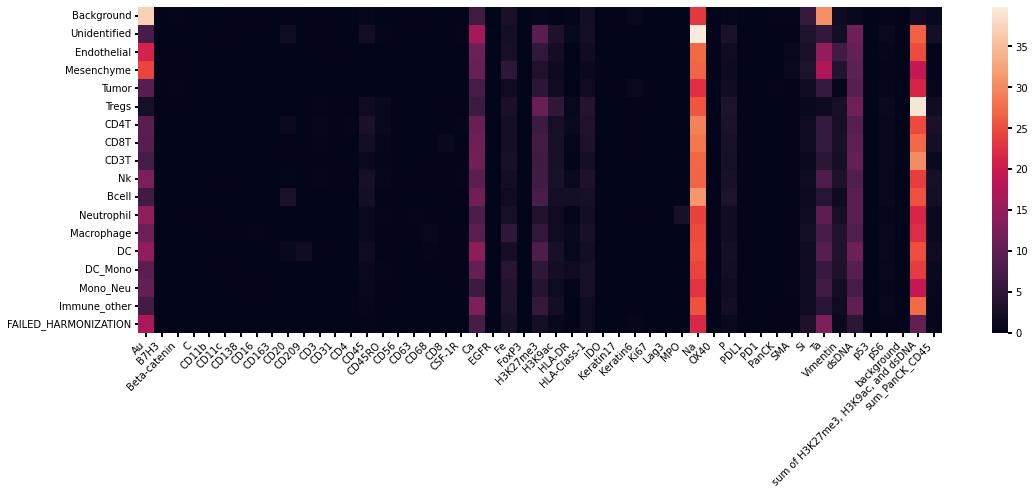

In [51]:
plt.figure(figsize = (18, 6))
sns.heatmap(averaged_panel, xticklabels=meta_data['channels'], yticklabels=meta_data['cell_types'].values())
plt.xticks(rotation=45, ha="right")
plt.savefig('')

In [53]:
#split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(all_means_X_bycell, all_y_bycell, test_size=0.20, random_state=42)

#train a multiclass logistic regression model to predict cell type based on the average expression profile of a cell
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred_test= clf.predict(X_test)
pickle.dump(clf, open('model.sav', 'wb'))

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5]),
 [Text(0.5, 0, 'Background'),
  Text(1.5, 0, 'Unidentified'),
  Text(2.5, 0, 'Endothelial'),
  Text(3.5, 0, 'Mesenchyme'),
  Text(4.5, 0, 'Tumor'),
  Text(5.5, 0, 'Tregs'),
  Text(6.5, 0, 'CD4T'),
  Text(7.5, 0, 'CD8T'),
  Text(8.5, 0, 'CD3T'),
  Text(9.5, 0, 'Nk'),
  Text(10.5, 0, 'Bcell'),
  Text(11.5, 0, 'Neutrophil'),
  Text(12.5, 0, 'Macrophage'),
  Text(13.5, 0, 'DC'),
  Text(14.5, 0, 'DC_Mono'),
  Text(15.5, 0, 'Mono_Neu'),
  Text(16.5, 0, 'Immune_other'),
  Text(17.5, 0, 'FAILED_HARMONIZATION')])

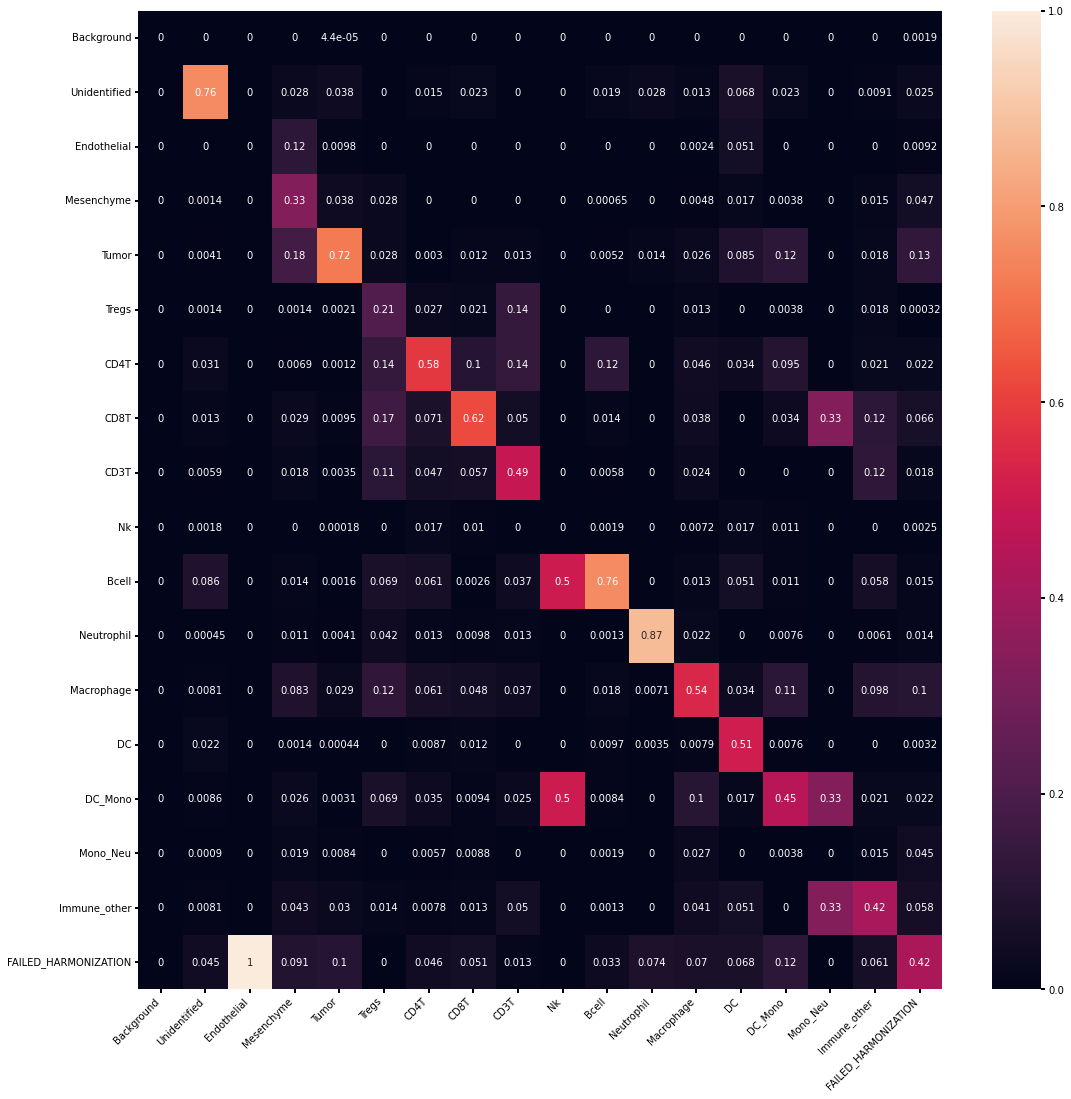

In [55]:
results_matrix = confusion_matrix(y_test, y_pred_test, normalize='pred')

plt.figure(figsize=(18, 18))
sns.heatmap(results_matrix, xticklabels=meta_data['cell_types'].values(), yticklabels=meta_data['cell_types'].values(), annot=True)
plt.xticks(rotation=45, ha="right")